<a href="https://kritikseth.github.io/ipynbtagredirect" target="_parent"><img src="https://raw.githack.com/kritikseth/kritikseth/master/assets/icons/kritik_ipynbtagredirect.svg" alt="Kritik Seth"/></a>

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip -q
!unzip /content/smsspamcollection.zip

Archive:  /content/smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
!pip install swachhdata -q

     |████████████████████████████████| 133kB 6.5MB/s 
     |████████████████████████████████| 102kB 5.2MB/s 
     |████████████████████████████████| 245kB 8.2MB/s 
     |████████████████████████████████| 327kB 9.0MB/s 


In [ ]:
import pandas as pd
import numpy as np

import nltk
nltk.download('popular', quiet=True)
from swachhdata.text import *

In [ ]:
data = pd.read_csv('/content/SMSSpamCollection', sep='\t', names=['Type', 'SMS'])

In [ ]:
data.head()

,Type,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data['Type'] = data['Type'].replace({'ham':0, 'spam':1})

In [ ]:
data['Type'].value_counts()

0    4825
1     747
Name: Type, dtype: int64

# Text Preprocessing

In [ ]:
data['SMS'] = data['SMS'].str.lower()

In [ ]:
html = htmlRecast(verbose=1)
data['SMS'] = html.setup_recast(data['SMS'])

In [ ]:
punc = PunctuationRecast(verbose=1)
data['SMS'] = punc.setup_recast(data['SMS'])

In [ ]:
stopwords = StopWordsRecast(package='nltk', verbose=1)
data['SMS'] = stopwords.setup_recast(data['SMS'])

In [ ]:
emoji = EmojiRecast(process='remove', verbose=1)
data['SMS'] = emoji.setup_recast(data['SMS'])

In [ ]:
num = NumberRecast(process='remove', verbose=1)
data['SMS'] = num.setup_recast(data['SMS'])

In [ ]:
data.head()

,Type,SMS
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st...
3,0,u dun say early hor u c already say
4,0,nah think goes usf lives around though


# Wordcloud

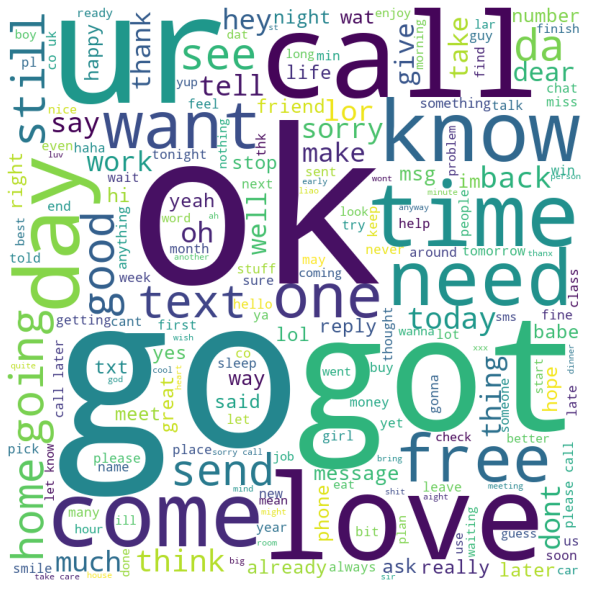

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
doc = ''

for sent in data['SMS']:
    doc += sent + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(doc) 
                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
vectors = tfidf.fit_transform(data['SMS'])

In [ ]:
vectors = vectors.toarray()

# Train Test Split

In [ ]:
from sklearn.model_selection  import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectors, data['Type'], test_size=0.2, random_state=1)

# Model Building

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [ ]:
def train_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    print(classification_report(y_test, ypred))
    return model, ypred

In [ ]:
mnb = MultinomialNB()
mnb, ypred = train_test_model(mnb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       968
           1       0.99      0.80      0.88       147

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [ ]:
rfc = RandomForestClassifier()
rfc, ypred = train_test_model(rfc, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       968
           1       0.99      0.86      0.92       147

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
lgb = LGBMClassifier()
lgb, ypred = train_test_model(lgb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       968
           1       0.93      0.93      0.93       147

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
xgb = XGBClassifier()
xgb, ypred = train_test_model(xgb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       968
           1       0.91      0.80      0.86       147

    accuracy                           0.96      1115
   macro avg       0.94      0.90      0.92      1115
weighted avg       0.96      0.96      0.96      1115



# Handling Class Imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## SMOTE (Synthetic Minority Oversampling Technique)

In [ ]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(vectors, data['Type'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=1)

In [ ]:
mnb = MultinomialNB()
mnb, ypred = train_test_model(mnb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       973
           1       0.96      0.99      0.98       957

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930



In [ ]:
rfc = RandomForestClassifier()
rfc, ypred = train_test_model(rfc, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       973
           1       1.00      0.99      0.99       957

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



In [ ]:
lgb = LGBMClassifier()
lgb, ypred = train_test_model(lgb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       973
           1       1.00      0.98      0.99       957

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



In [ ]:
xgb = XGBClassifier()
xgb, ypred = train_test_model(xgb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       973
           1       0.97      0.97      0.97       957

    accuracy                           0.97      1930
   macro avg       0.97      0.97      0.97      1930
weighted avg       0.97      0.97      0.97      1930



## Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=1)
X_rus, y_rus = rus.fit_resample(vectors, data['Type'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=1)

In [ ]:
mnb = MultinomialNB()
mnb, ypred = train_test_model(mnb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       148
           1       0.92      0.93      0.92       151

    accuracy                           0.92       299
   macro avg       0.92      0.92      0.92       299
weighted avg       0.92      0.92      0.92       299



In [ ]:
rfc = RandomForestClassifier()
rfc, ypred = train_test_model(rfc, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       148
           1       0.99      0.92      0.95       151

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.96      0.95      0.95       299



In [ ]:
lgb = LGBMClassifier()
lgb, ypred = train_test_model(lgb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       148
           1       0.96      0.93      0.95       151

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.95      0.95      0.95       299



In [ ]:
xgb = XGBClassifier()
xgb, ypred = train_test_model(xgb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       148
           1       0.94      0.90      0.92       151

    accuracy                           0.92       299
   macro avg       0.92      0.92      0.92       299
weighted avg       0.92      0.92      0.92       299



## Oversampling

In [ ]:
ros = RandomOverSampler(random_state=1)
X_ros, y_ros = ros.fit_resample(vectors, data['Type'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=1)

In [ ]:
mnb = MultinomialNB()
mnb, ypred = train_test_model(mnb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       973
           1       0.96      0.99      0.98       957

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930



In [ ]:
rfc = RandomForestClassifier()
rfc, ypred = train_test_model(rfc, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       973
           1       1.00      1.00      1.00       957

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930



In [ ]:
lgb = LGBMClassifier()
lgb, ypred = train_test_model(lgb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       973
           1       0.99      1.00      0.99       957

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



In [ ]:
xgb = XGBClassifier()
xgb, ypred = train_test_model(xgb, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       973
           1       0.97      0.91      0.94       957

    accuracy                           0.94      1930
   macro avg       0.94      0.94      0.94      1930
weighted avg       0.94      0.94      0.94      1930

